In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogscats/"
sz = 224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [8]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [9]:
file = os.listdir(f'{PATH}valid/cats')[:5]

In [10]:
file

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg']

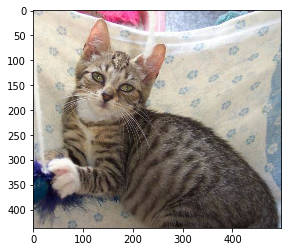

In [11]:
img = plt.imread(f'{PATH}valid/cats/{file[0]}')
plt.imshow(img)

In [12]:
img.shape

(437, 499, 3)

In [13]:
img[:4,:4]

array([[[211, 212, 217],
        [210, 211, 216],
        [208, 207, 212],
        [202, 202, 204]],

       [[200, 201, 206],
        [198, 199, 203],
        [196, 195, 200],
        [193, 193, 195]],

       [[193, 192, 197],
        [189, 189, 191],
        [185, 183, 186],
        [186, 184, 187]],

       [[197, 195, 196],
        [189, 187, 188],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

In [14]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms = tfms_from_model(arch,sz))
learn = ConvLearner.pretrained(arch,data,precompute=True)
learn.fit(0.01,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.049363   0.023805   0.991211  
    1      0.044227   0.023711   0.990723                     



[0.023711406800430268, 0.99072265625]

In [15]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
data.classes

['cats', 'dogs']

In [17]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [18]:
log_preds[:10]

array([[ -0.0001 ,  -9.21694],
       [ -0.00266,  -5.92987],
       [ -0.00083,  -7.09272],
       [ -0.00056,  -7.49359],
       [ -0.00042,  -7.7717 ],
       [ -0.00072,  -7.2393 ],
       [ -0.00005,  -9.99998],
       [ -0.00001, -11.17619],
       [ -0.00183,  -6.30388],
       [ -0.00022,  -8.43545]], dtype=float32)

In [32]:
preds = np.argmax(log_preds,axis = 1)
probs = np.exp(log_preds[:,1])

In [33]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4,replace = False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y) == is_correct)

In [34]:
def plot_val_with_title(idxs,title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs),rows = 1,titles= title_probs)

In [37]:
def plots(ims,figsize = (12,6),rows = 1,titles = None):
    f = plt.figure(figsize = figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows,len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:sp.set_title(titles[i],fontsize = 16)
        plt.imshow(ims[i])
        

Correctly classified


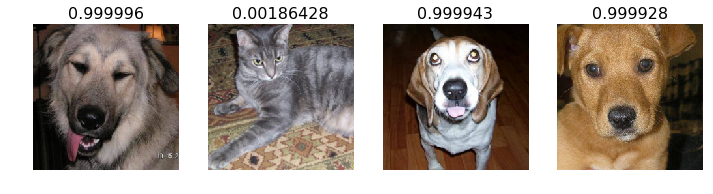

In [40]:
#1. A few correct labels at random
plot_val_with_title(rand_by_correct(True),'Correctly classified')

Incorrectly classified


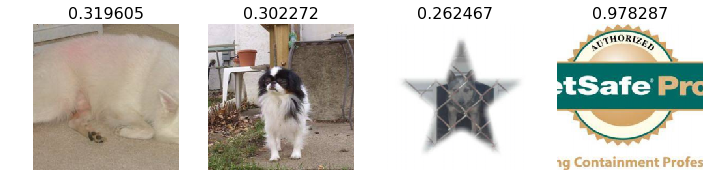

In [41]:
#2.A few incorrect labels at random
plot_val_with_title(rand_by_correct(False),"Incorrectly classified")

In [44]:
def most_by_mask(mask,mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y,is_correct):
    mult = -1 if (y ==1) ==is_correct else 1
    return most_by_mask(((preds == data.val_y) == is_correct) & (data.val_y ==y),mult)

Most correct cats


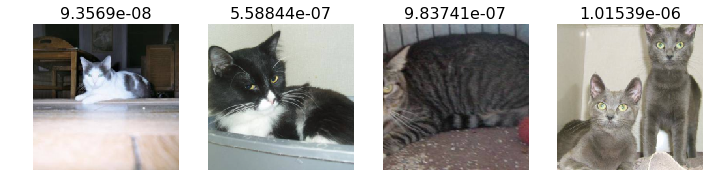

In [45]:
plot_val_with_title(most_by_correct(0,True),"Most correct cats")

Most correct dogs


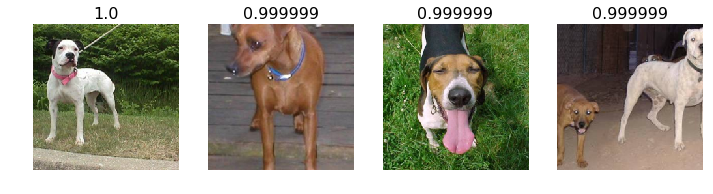

In [46]:
plot_val_with_title(most_by_correct(1,True),"Most correct dogs")

Most incorrect cats


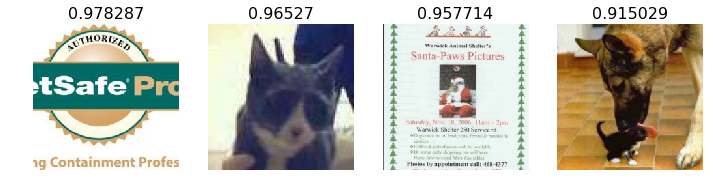

In [47]:
plot_val_with_title(most_by_correct(0,False),"Most incorrect cats")


Most incorrect dogs


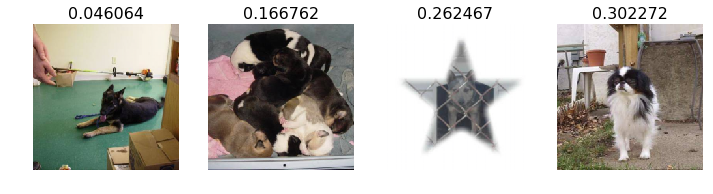

In [48]:
plot_val_with_title(most_by_correct(1,False),"Most incorrect dogs")

Most uncertain prediction


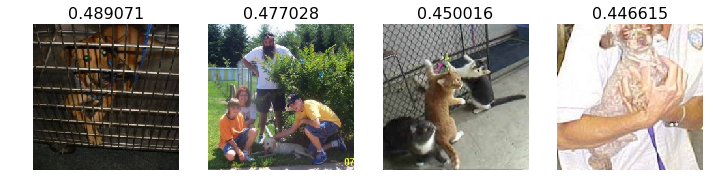

In [49]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain,"Most uncertain prediction")

In [52]:
learn = ConvLearner.pretrained(arch,data,precompute = True)

In [53]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 79%|███████▊  | 283/360 [00:04<00:01, 60.55it/s, loss=0.749]


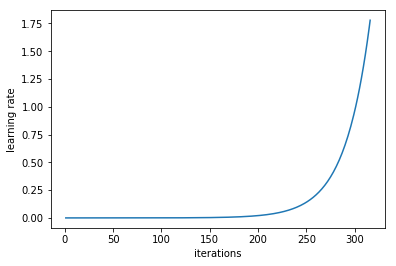

In [56]:
learn.sched.plot_lr()

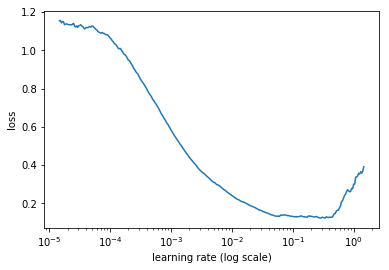

In [58]:
learn.sched.plot()

In [59]:
#applying transformation on images so to avoid overfitting
tfms = tfms_from_model(resnet34,sz,aug_tfms = transforms_side_on,max_zoom = 1.1)

In [61]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH,bs=2,tfms = tfms,num_workers = 1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [62]:
ims = np.stack([get_augs() for i in range(6)])

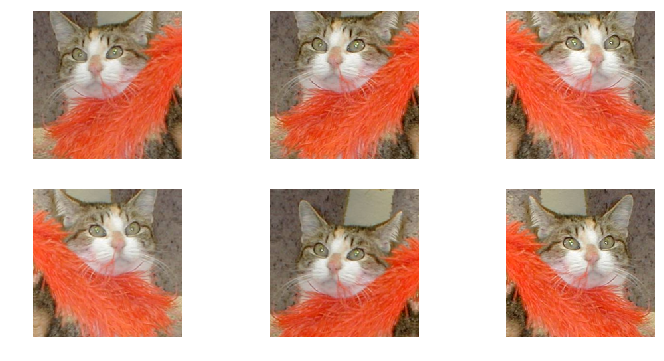

In [63]:
plots(ims,rows =2)

In [66]:
data = ImageClassifierData.from_paths(PATH,tfms = tfms)
learn = ConvLearner.pretrained(arch,data,precompute = True)

In [67]:
learn.fit(1e-2,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.061155   0.02872    0.990723  



[0.028720354661345482, 0.99072265625]

In [68]:
learn.precompute = False

In [69]:
learn.fit(1e-2,3,cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.044311   0.027032   0.991211  
    1      0.045979   0.027696   0.990234                     
    2      0.045793   0.028005   0.991211                     



[0.028005114727420732, 0.9912109375]

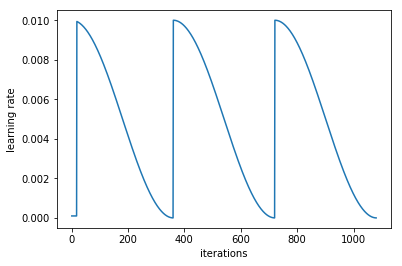

In [71]:
learn.sched.plot_lr()

In [72]:
learn.save('224_lastlayer')

In [73]:
learn.load('224_lastlayer')

In [74]:
learn.unfreeze()

In [75]:
lr = np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr,3,cycle_len = 1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))